In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np
!pip install folium
import folium

     |████████████████████████████████| 93 kB 1.2 MB/s eta 0:00:011


In [2]:
!pip install beautifulsoup4
import os
!conda install -c conda-forge folium=0.5.0 --yes 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

     |████████████████████████████████| 115 kB 3.1 MB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          73 KB

The following NEW packages will be INSTALLED:

  folium             conda-forge/noarch::folium-0.5.0-py_

In [4]:
 conda update -n base conda

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

CLIENT_ID = 'KUKHGXJ2T4SKDTZURMZ2CBRETYGSKKQSEXNXHXBXWOW2DZB2' # your Foursquare ID
CLIENT_SECRET = 'RMCTUXYWHLWYNQ1ZQYLAUHX2KM2ELUUZEIC3Q5N5X0Z0LJVJ' # your Foursquare Secret
LIMIT = 40
VERSION = '20200719'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Your credentails:
CLIENT_ID: KUKHGXJ2T4SKDTZURMZ2CBRETYGSKKQSEXNXHXBXWOW2DZB2
CLIENT_SECRET:RMCTUXYWHLWYNQ1ZQYLAUHX2KM2ELUUZEIC3Q5N5X0Z0LJVJ


Now lets use the above codes to get our initial NYC data

In [7]:
ny_data = get_new_york_data()
ny_data.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [8]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five boroughs

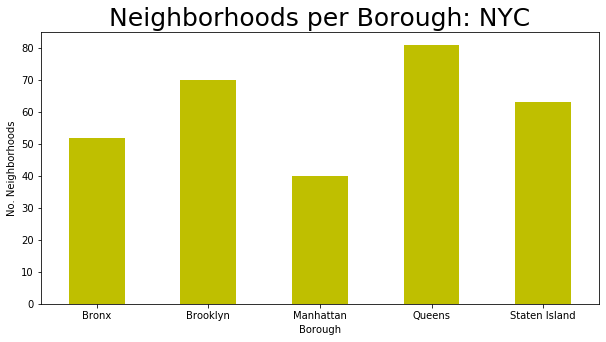

In [10]:
clr = 'y'
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 25)
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('No. Neighborhoods',fontsize = 10)
plt.xticks(rotation = 'horizontal')
plt.show()

We can see that Queens borough has the most number of neighborhoods. Let us now prepare neighborhood lst that contains Japanese restaurants

Lets analyze how many Japanese restaurants are present in each neighborhood and burough and plot the results

In [11]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
Japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(Japanese_resturants)))
    print(row)
    for resturant_detail in Japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        Japanese_rest_ny = Japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1;
    print('Done!')

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
Done!
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
Done!
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
Done!
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
Done!
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
Done!
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
Done!
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
Done!
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
Done!
( 9 / 

In [12]:
Japanese_rest_ny.to_csv('Japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare


In [13]:
Japanese_rest_ny = pd.read_csv('Japanese_rest_ny_tocsv1.csv')
Japanese_rest_ny.head()

,Unnamed: 0,Borough,Neighborhood,ID,Name
0,0,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi
1,1,Brooklyn,Windsor Terrace,4dba07b7fa8c2e303f1b124f,Yama Asian Bistro
2,2,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki
3,3,Brooklyn,Williamsburg,51f9b7b3498eefe896caeb23,Shalom Japan
4,4,Brooklyn,Bedford Stuyvesant,5b3bcb69bfc6d0002ca9bf17,Warude


In [15]:
Japanese_rest_ny = pd.read_csv('Japanese_rest_ny_tocsv1.csv')
Japanese_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
57,57,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
58,58,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
59,59,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
60,60,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
61,61,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [14]:
Japanese_rest_ny.shape

(62, 5)

We can see that though Manhattan has the least number of neighborhoods, it has many Japanese restaurants, followed by Queens, Brooklyn and Staten Island

We shall continue to analyze how many Japanese restaurants are present in total in the top neighborhoods and classify which restaurant in the populous neighborhood has high and low user ratings to detemine where I can open a new Japanese restaurant

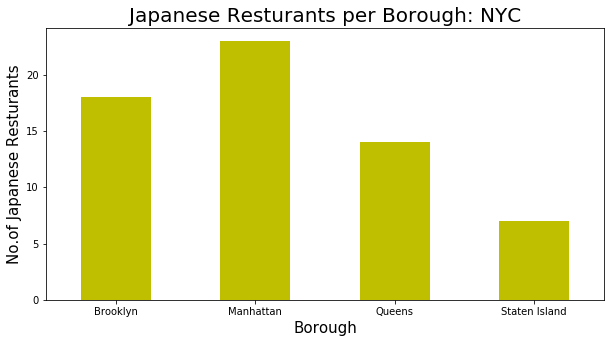

In [16]:
Japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Japanese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Japanese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

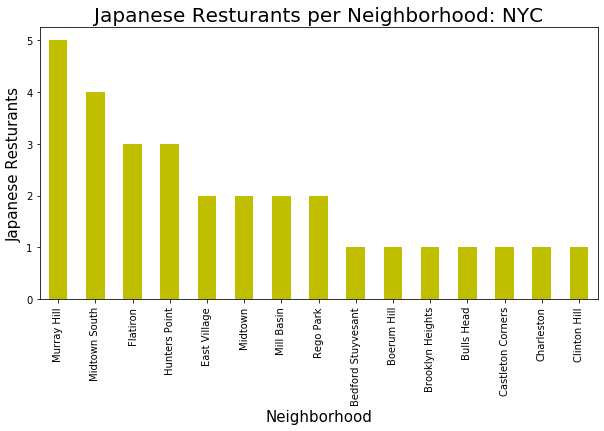

In [17]:
NoofNeighbors = 15 #Top boroughs only,rest are same or none available
Japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NoofNeighbors).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Japanese Resturants', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

In [61]:
Japanese_rest_ny[Japanese_rest_ny['Neighborhood']=='Murray Hill']
#MurrayHill has the maximum number of restaurants

,Borough,Neighborhood,ID,Name,Rating


In [58]:
# prepare neighborhood list that contains japanese resturants

column_names=['Borough', 'Neighborhood', 'ID','Name','Rating']
Japanese_rest_stat_ny=pd.DataFrame(columns=column_names)
count=1

for row in Japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name,Rating=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        Borough, Neighborhood,id,name,rating=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        Borough,Neighborhood,id,name,rating=[0]*5
    print('(',count,'/',len(Japanese_rest_ny),')','processed')
    Japanese_rest_stat_ny = Japanese_rest_stat_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                              'Rating' : rating}, ignore_index=True)
    count+=1;
    print('Done!')

In [59]:
Japanese_rest_stats_ny.to_csv('Japanese_rest_stats_ny_csv.csv')
# I continue to save data to a .csv as I move through this project

In [60]:
Japanese_rest_stats_ny.shape

(0, 4)

In [41]:
Japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
Borough         62 non-null object
Neighborhood    62 non-null object
ID              62 non-null object
Name            62 non-null object
Rating          62 non-null object
dtypes: object(5)
memory usage: 2.5+ KB


In [42]:
Japanese_rest_stats_ny['Rating']=Japanese_rest_stats_ny['Rating'].astype('float64')
Japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
Borough         62 non-null object
Neighborhood    62 non-null object
ID              62 non-null object
Name            62 non-null object
Rating          62 non-null float64
dtypes: float64(1), object(4)
memory usage: 2.5+ KB


In [43]:
Japanese_rest_stats_ny.describe()

,Rating
count,62.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [44]:
# Resturant with maximum Ratings
Japanese_rest_stats_ny.iloc[Japanese_rest_stats_ny['Rating'].idxmax()]

Borough                0
Neighborhood    Brooklyn
ID                     0
Name                   0
Rating                 0
Name: 0, dtype: object

In [45]:
ny_neighborhood_stats=Japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Brooklyn,0.0
1,Manhattan,0.0
2,Queens,0.0
3,Staten Island,0.0


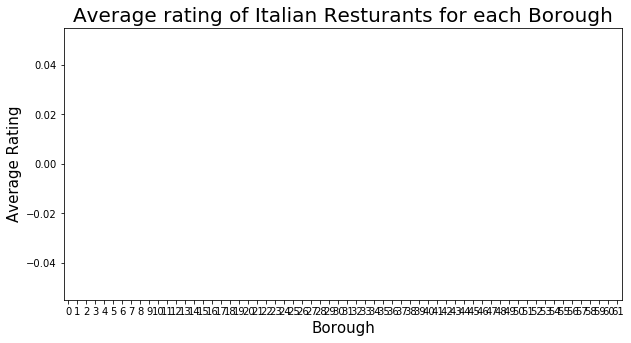

In [47]:
Japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [50]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>0]
ny_neighborhood_stats

,Neighborhood,Average Rating


In [51]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


In [52]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [53]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [57]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'